In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests

from collections import Counter

from PIL import Image
from io import BytesIO

warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
from classes.VAE import VariationalAutoencoder

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline


from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

from keras.applications.inception_v3 import InceptionV3, preprocess_input

Using TensorFlow backend.


### loading data

In [3]:
import cv2

def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath

def load_images(directory='', size=(64,64)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0

    imagePaths = list(list_images(directory))

    for path in imagePaths:

        if not('OSX' in path):

            path = path.replace('\\','/')

            image = cv2.imread(path) #Reading the image with OpenCV
            image = cv2.resize(image,size) #Resizing the image, in case some are not of the same size

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    return images

In [4]:
images=load_images('data')

### reshaping images, making train val test sets and plotting example images

In [5]:
# Convert list with images to numpy array and reshape it
X = np.array(images).reshape(-1, 64, 64, 3)

# Scaling data in array
X = X / 255.0

from sklearn.model_selection import train_test_split

# Splitting data to train and test datasets
X_train, X_test = train_test_split(X, test_size = 0.2, shuffle = True, random_state = 66)

In [6]:
n = int(len(X_test)/2)
X_valid = X_test[:n]
X_test = X_test[n:]

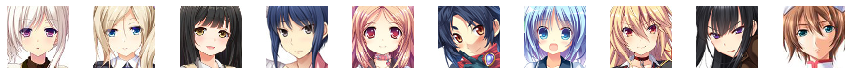

In [7]:
n_to_show = 10
example_idx = np.random.choice(range(len(X)), n_to_show)
example_images = X[example_idx]


fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.imshow(img)

### building an imagedatagenerator to increase training set

- Step #1: An input batch of images is presented to the ImageDataGenerator.
- Step #2: The ImageDataGenerator  transforms each image in the batch by a series of random translations, rotations, etc.
- Step #3: The randomly transformed batch is then returned to the calling function.





The ImageDataGenerator  is not returning both the original data and the transformed data — the class only returns the randomly transformed data.
We call this “in-place” and “on-the-fly” data augmentation because this augmentation is done at training time (i.e., we are not generating these examples ahead of time/prior to training).




ImageDataGenerator does NOT accept an input batch of images, randomly transforms the batch, and then returns both the original batch and modified data — again, this is NOT what the Keras ImageDataGenerator does. Instead, the ImageDataGenerator class will return just the randomly transformed data.

In [8]:
### Defining ImageDataGenerator 
datagen = ImageDataGenerator(rotation_range = 45, # Degree range for random rotations
                            zoom_range = 0.2, # Range for random zoom 
                            horizontal_flip = True, # Randomly flip inputs horizontally
                            width_shift_range = 0.15, # Range for horizontal shift 
                            height_shift_range = 0.15, # Range for vertical shift 
                            shear_range = 0.2) # Shear Intensity

datagen.fit(X_train)

### building the Variational Autoencoder

In [9]:
VAE = VariationalAutoencoder(
    input_dim = (64,64,3)
    , encoder_conv_filters = [32,64,64,64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [2,2,2,2]
    , decoder_conv_t_filters = [64,64,32,3]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    ### 3 for the last decoder layer as we as we want RGB images
    , decoder_conv_t_strides = [2,2,2,2]
    , z_dim = 200
    , use_batch_norm=True
    , use_dropout=True)

VAE._build()

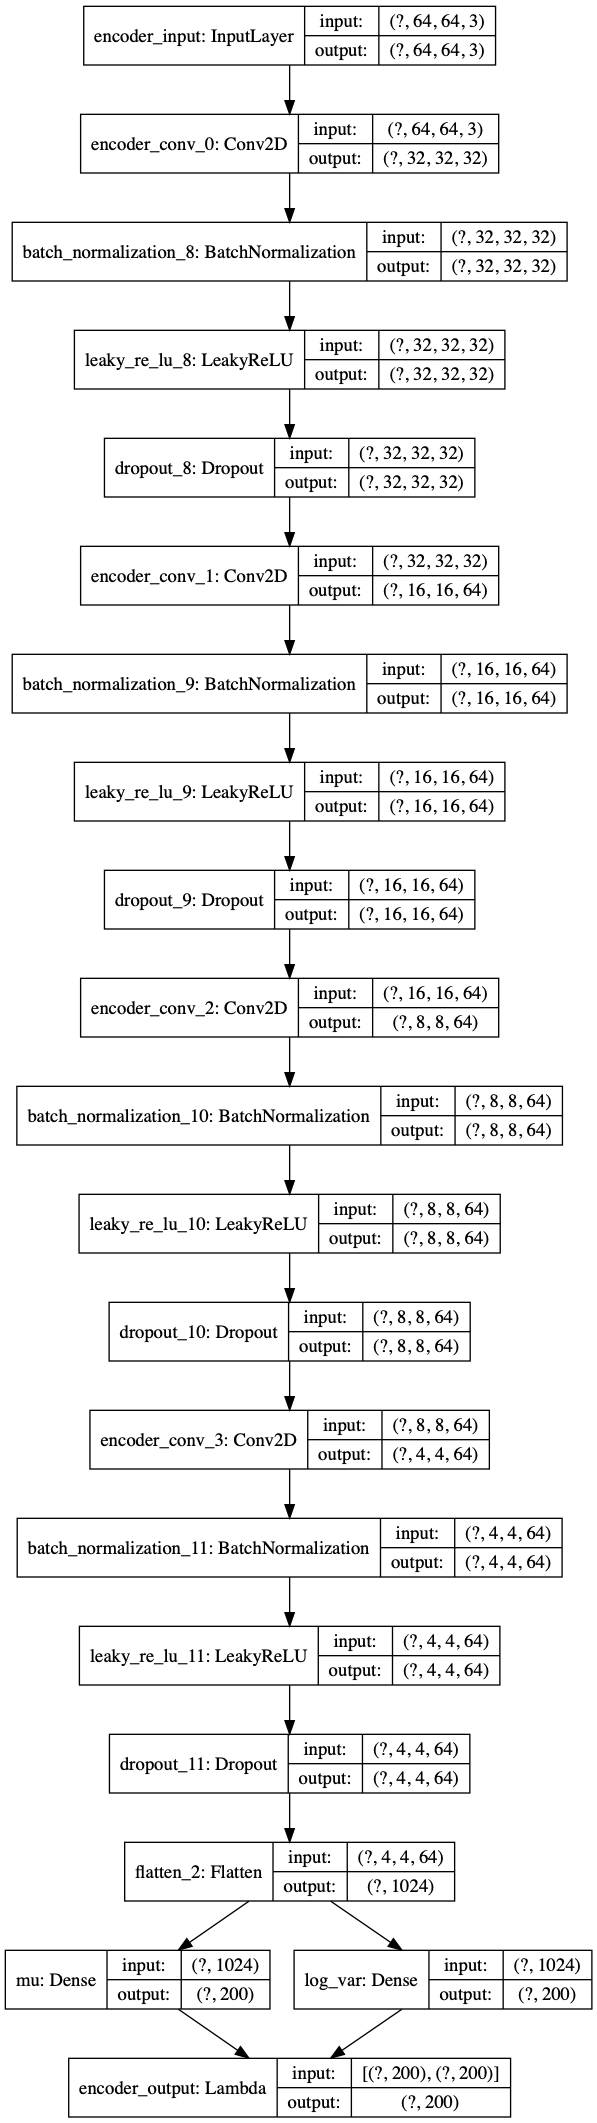

In [10]:
keras.utils.plot_model(VAE.encoder, "figures/Var_autoencoder_encoder_model.png", show_shapes=True)

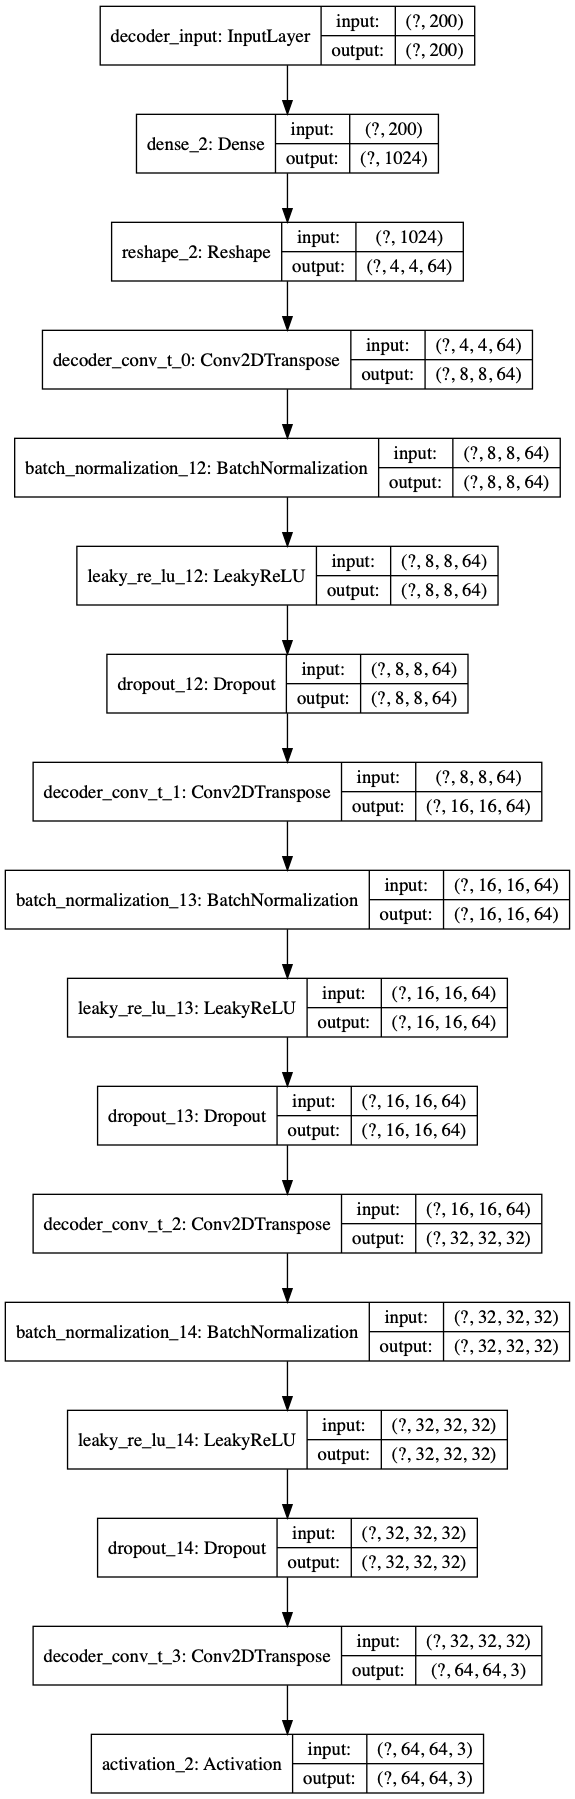

In [11]:
keras.utils.plot_model(VAE.decoder, "figures/Var_autoencoder_decoder_model.png", show_shapes=True)

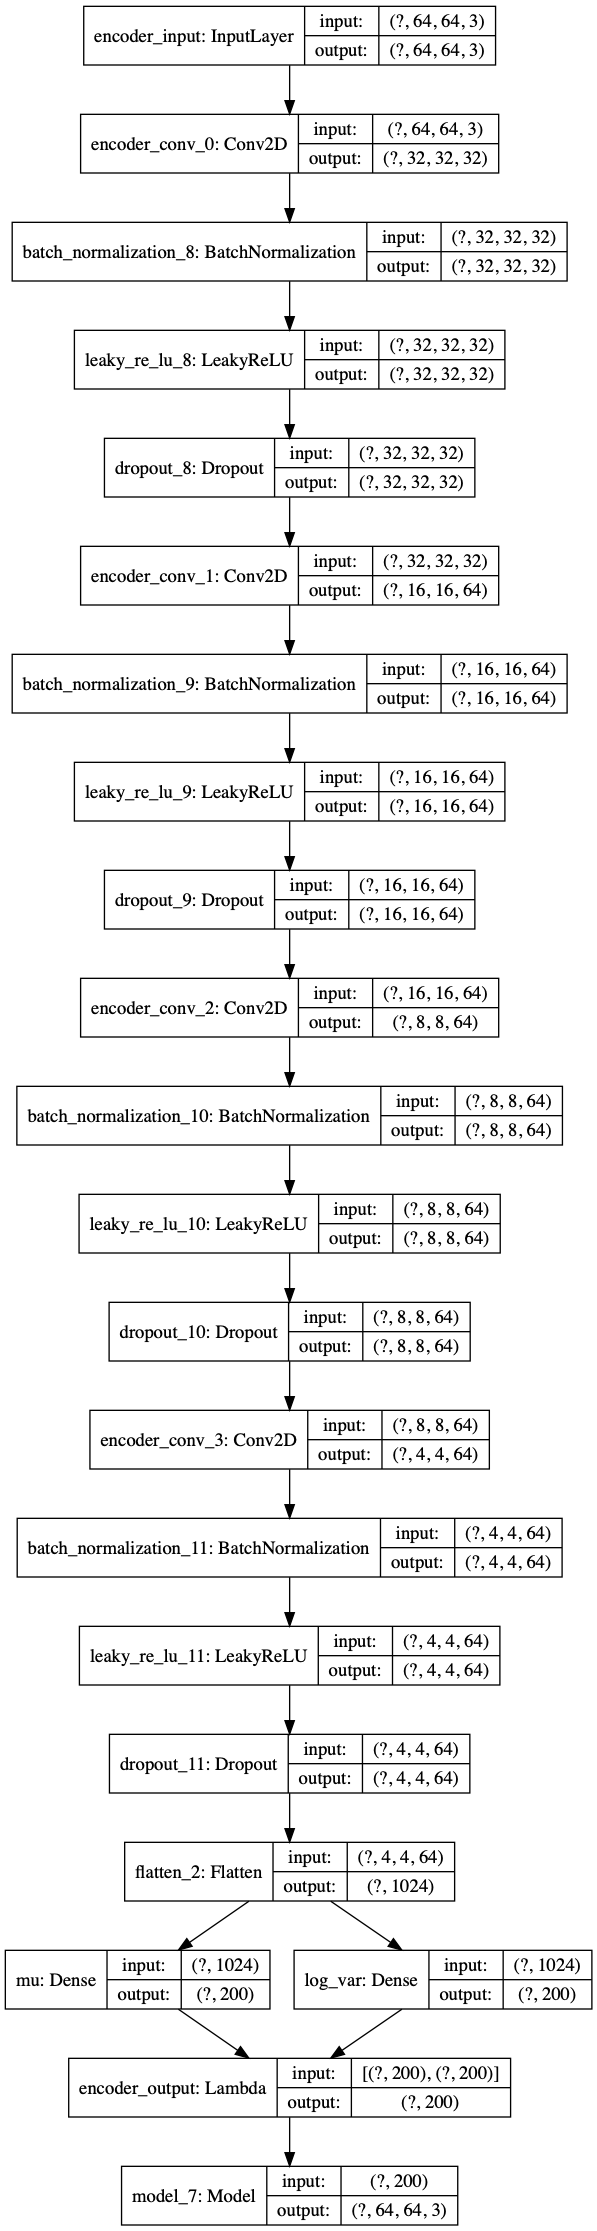

In [12]:
keras.utils.plot_model(VAE.model, "figures/Var_autoencoder_model.png", show_shapes=True)

In [13]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000

VAE.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [14]:
#optimizer = Adam(lr=LEARNING_RATE)

#def r_loss(y_true, y_pred):
 #   return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

#VAE.model.compile(optimizer=optimizer, loss = r_loss, metrics = ['accuracy'])

In [15]:
checkpointer = ModelCheckpoint(filepath='saved_models/var_IGMAUG_autoencoder.h5',
                               verbose=2, save_best_only=True)

early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True)

In [23]:
history = VAE.model.fit_generator(
                    datagen.flow(X_train, X_train, batch_size=32),
                    #batch_size = 32,
                    steps_per_epoch=len(X_train) / 32, 
                    epochs= 50, 
                    verbose=2,
                    validation_data=(X_valid, X_valid),
                    callbacks=[checkpointer, early_stopping_cb]
                    )

Epoch 1/50
 - 66s - loss: 54.8714 - vae_r_loss: 51.3964 - vae_kl_loss: 3.4741 - accuracy: 0.7549 - val_loss: 52.8778 - val_vae_r_loss: 49.4753 - val_vae_kl_loss: 3.4025 - val_accuracy: 0.7688

Epoch 00001: val_loss did not improve from 52.43125
Epoch 2/50
 - 64s - loss: 54.7877 - vae_r_loss: 51.3123 - vae_kl_loss: 3.4731 - accuracy: 0.7565 - val_loss: 53.0198 - val_vae_r_loss: 49.3564 - val_vae_kl_loss: 3.6633 - val_accuracy: 0.7602

Epoch 00002: val_loss did not improve from 52.43125
Epoch 3/50
 - 67s - loss: 54.6676 - vae_r_loss: 51.1876 - vae_kl_loss: 3.4802 - accuracy: 0.7552 - val_loss: 52.7147 - val_vae_r_loss: 49.5685 - val_vae_kl_loss: 3.1462 - val_accuracy: 0.7638

Epoch 00003: val_loss did not improve from 52.43125
Epoch 4/50
 - 67s - loss: 54.5579 - vae_r_loss: 51.1281 - vae_kl_loss: 3.4289 - accuracy: 0.7569 - val_loss: 52.3877 - val_vae_r_loss: 48.7749 - val_vae_kl_loss: 3.6128 - val_accuracy: 0.7753

Epoch 00004: val_loss improved from 52.43125 to 52.38772, saving model t

### training history plots

In [17]:
list(history.history.keys())

['val_loss',
 'val_vae_r_loss',
 'val_vae_kl_loss',
 'val_accuracy',
 'loss',
 'vae_r_loss',
 'vae_kl_loss',
 'accuracy']

In [18]:
def history_plot(history, n):

    tot_pairs = np.int(len(list(history.history.keys()))/2)

    plt.figure(figsize=(18,12))

    for i in range(tot_pairs):

        plt.subplot(np.int(tot_pairs)*100+11+np.int(i))
        plt.plot(history.history[list(history.history.keys())[i]][n:],
                                     color='#4876ff', label = list(history.history.keys())[i])
        plt.plot(history.history[list(history.history.keys())[i + tot_pairs]][n:],
                                     color='slategray', label = list(history.history.keys())[i + tot_pairs])
        plt.xlabel("Epochs")
        plt.ylabel(list(history.history.keys())[i+tot_pairs])
        plt.legend()
        plt.grid()
        plt.title(list(history.history.keys())[i+tot_pairs])

    plt.show()

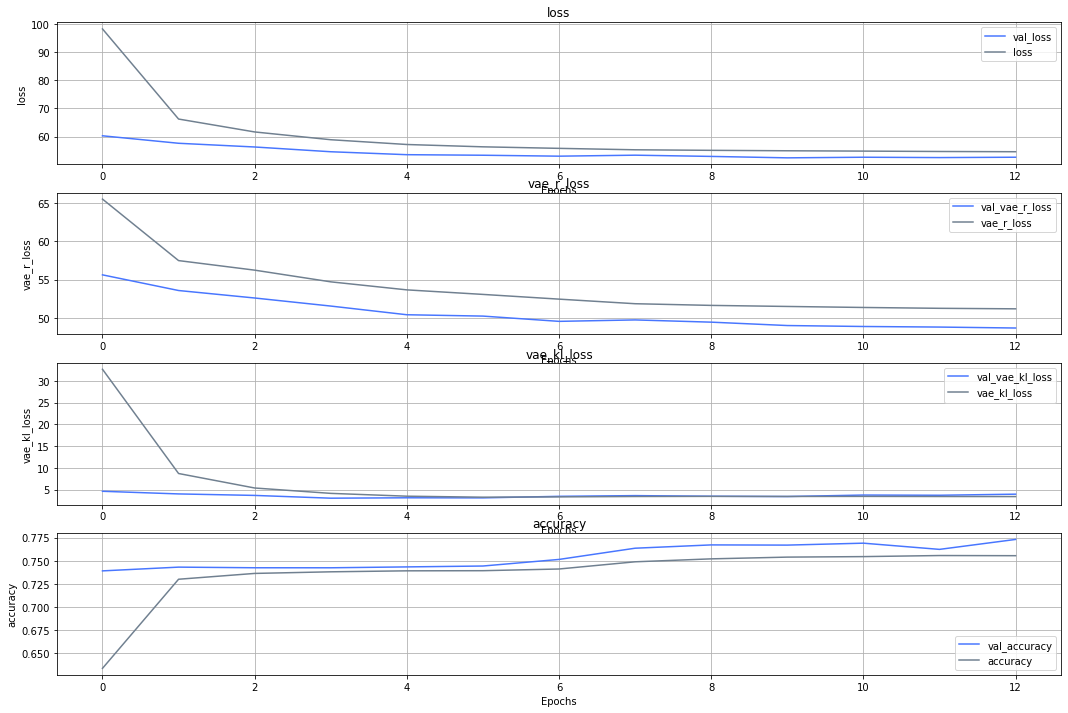

In [19]:
history_plot(history, 0)

### load model from training the variational neural net

In [ ]:
model = keras.models.load_model("save/var_IMGAUG_autoencoder.h5")

### evaluating on test set

In [20]:
score = VAE.model.evaluate(X_test, X_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[3])

Test loss: 51.86184010833004
Test accuracy: 0.7729633450508118


### analysis of variational autoencoder

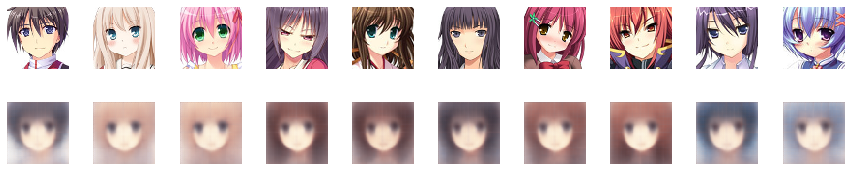

In [26]:
n_to_show = 10
example_idx = np.random.choice(range(len(X)), n_to_show)
example_images = X[example_idx]
#example_images = X[np.array([230, 7809])]

z_points = VAE.encoder.predict(example_images)

reconst_images = VAE.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i]#.squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    #ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i]#.squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img)
    
plt.savefig('model_images/VAE_IMGAUG_encoder_decoder_images.png')

### newly generated points

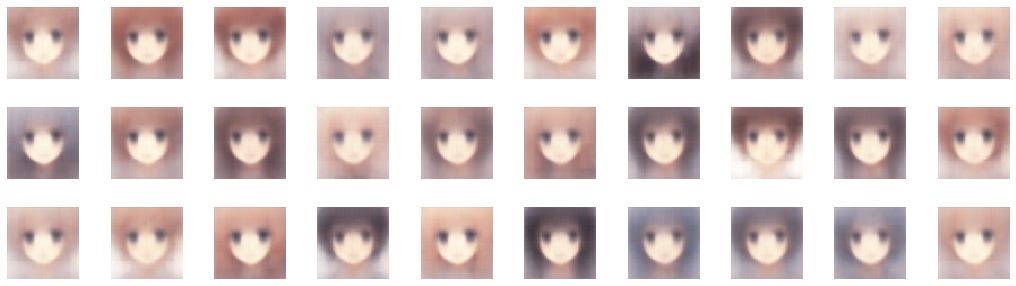

In [27]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show, VAE.z_dim))

reconst = VAE.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.savefig('model_images/VAE_IMGAUG_new_images.png')
    
plt.show()